In [1]:
import pandas as pd
from plotly import offline as pyo
from plotly import graph_objects as go
import numpy as np
import os
from scipy import ndimage as ndi
from jw_utils import app_functions as afns
from jw_utils import parse_gff as pgf
from jw_utils import parse_fasta as pf
from jw_utils import genome_utils as gu
from jw_utils import parse_gbk as pgb
from jw_utils import plotly_utils as pu
from jw_utils import file_utils as fu
from jw_utils import gene_profile as gp
from Bio import SeqIO
import bisect
import processing as pr

hello


## Description of initial steps
#### raw data description './data/...'
working directory: ('~/Dropbox/Trestle_projects/Eustaquio_lab/RNAseq_dash_app')
1) 5 chromosomes/plasmids: ('BF000000.1', 'BF000000.2', 'BF000000.3', 'BF000000.4', 'BF000000.5') './data/references' 
    - combined these files into one fasta ( './data/references/concat_references.fa' )
2) 12 paired end fastq files (6 R1 +  6 R2) ('../Illumina_RNA_Reads/fastq_files')
    - aligned with bowtie2 with our nextflow pipeline (see the multiqc report) using standard settings (../new_alignments/Bowtie_aligned')
    - extracted just 5' (rna) end of the paired end segment
        -5’ end of reads with flags 147 or 163 faced same direction as predicted RNAs



#### All paths to data

In [2]:
path_to_valcount_dir = './results/analysis/value_counts'
path_to_annot_file = './data/references/Reference_FERM_BP3421.gbk'
contig_names = ['BF000000.1','BF000000.2','BF000000.3','BF000000.4','BF000000.5']
path_to_fa_genomes = './data/references/concat_references.fa'

### Make a example of clean data and difference kernal and plot it

In [3]:
y0 = np.full(50, 0)
y1 = np.full(50, 1)
y = np.concatenate([y0,y1])
x = np.array(range(len(y)))
t = ndi.convolve(y, [1,0,-1], mode='reflect')
fig = pu.quick_line(x =x, y = t, name='convolved w diff kernal' )
data = pu.quick_line(x =x, y = y, name='clean data'  )['data'][0]
fig = fig.add_trace(data)
pyo.plot(fig)


'temp-plot.html'

### First processing steps
1) Make dataframe of summed reads at each genomic position from all experiments
2) Make transcription start site TssFinder object
3) Find all tss windows and return df dictionary with reads for each gene. 100 nt before start codon up to start codon
4) Make figure dictionary containing plotly figs for reads in the tss window and for the diff kernal-convolved reads


In [102]:
import processing as pr
df = pr.get_read_sums(path_to_valcount_dir,'BF000000.1')
tf_sums = gp.TssFinder(path_to_annot_file, val_counts_df=df, contig_name='BF000000.1')
tss_windows = tf_sums.get_region_hits(read_density_cut=0.2)
fig_dict= pr.make_fig_dict(path_to_annot_file,contig_name='BF000000.1', kernal_type='diff',plot_kernal=False, read_density_cut=0.2)

./results/analysis/value_counts/BF000000.1_BAO_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_2_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_2_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_3_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_1_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAO_2_filtered.txt_val_cnts.csv
./results/analysis/value_counts/BF000000.1_BAN_2_filtered.txt_val_cnts.csv


In [105]:
print(gb_dict['BF000000.1']['tmp_003403'].qualifiers['product'])
f = fig_dict['tmp_003403']

['non-specific DNA-binding protein DpsA']


'temp-plot.html'

In [109]:
print(gb_dict['BF000000.1']['tmp_003403'].qualifiers['product'])
print(gb_dict['BF000000.1']['tmp_003403'].location.start)
print(gb_dict['BF000000.1']['tmp_003403'].location.end)

['non-specific DNA-binding protein DpsA']
3746411
3746900


In [ ]:
fig_dict= pr.make_fig_dict(path_to_annot_file,contig_name='BF000000.1', kernal_type='diff',plot_kernal=False, read_density_cut=0.2)
genes= list(fig_dict.keys()) 
plus_genes_tss = list(set(genes).intersection(set(tf_sums.plus_strand_genes)))  #get all genes on the +strand that have windows
gb_dict = pgb.build_genbank_dict(path_to_annot_file)



def get_tss(tss_window):
    ser = ndi.convolve(tss_window,[1,0,-1])
    df = pd.DataFrame({gene:tss_window, 'diff_kernal':ser}, index = tss_window.index)
    filt1 = df.loc[:,'diff_kernal'] > 0
    filt2 = df.loc[:,gene] > 0
    df = df.loc[filt1,:] 
    df = df.loc[filt2,:]
    d = {}
    pre = {}
    post = {}
    window_size = 20
    for position in df.index:
        ave_reads = tss_window.sum()/tss_window.shape[0]
        pre_window_reads = tss_window.loc[position-window_size:position].sum()
        post_window_reads = tss_window.loc[position:position+window_size].sum()
        if post_window_reads/window_size < ave_reads/2:
            post_window_reads=0
        #print(f'position: {position} post_window_reads: {post_window_reads}')
        if pre_window_reads==0:
            pre_window_reads=pre_window_reads+0.000000001
        #print(f'position: {position} pre_window_reads: {pre_window_reads}\n')
        d[position]=(post_window_reads-pre_window_reads)/pre_window_reads
        pre[position] = pre_window_reads
        post[position] = post_window_reads
    df_hypoth = pd.DataFrame().from_dict(d, orient='index')
    df_hypoth.columns = ['enrichment']
    df_hypoth['post'] = list(post.values())
    df_hypoth['pre'] = list(pre.values())
    return df_hypoth.sort_values('enrichment', ascending=False)

# df_dict = {}
# for gene in plus_genes_tss:
#     df_dict[gene] = get_tss(tss_windows[gene])


###pick a gene
# gene = plus_genes_tss[8]
for i in range(50):
    gene = plus_genes_tss[i]
    print(gene)
    print(gb_dict['BF000000.1'][gene].location.strand)
    print(gb_dict['BF000000.1'][gene].qualifiers['product'])
    fig = fig_dict[gene]
    df = get_tss(tss_windows[gene])
    for i,pos in enumerate(df.index):
        if i<1:
            fig.add_vline(x=pos,line_width=1, line_dash='dash')
    fig.write_html(f'./figs/{gene}_putative_tss.html')

In [45]:
a = fig_dict[gene]
#pf.get_seq_region(path_to_fa_genomes,'BF000000.1',18757,18857)


In [ ]:
name='Histogram of read density in tss window'
ser = pd.Series(dens_dict.values())
#
trace = pu.plot_bar_with_outliers(ser, name=name, end = 20)
pyo.plot(go.Figure(data=trace))

### Sandbox for developing kernal to find steps

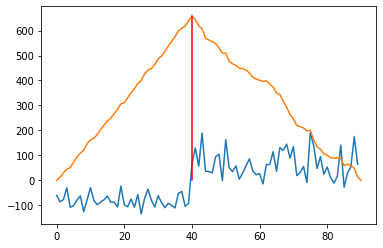

In [111]:
import numpy as np
from matplotlib import pyplot as plt


d = '''594.          568.55555556  577.22222222  624.55555556  546.66666667
552.88888889  575.55555556  592.33333333  528.88888889  576.11111111
625.          574.22222222  556.33333333  567.66666667  576.66666667
591.66666667  566.33333333  567.33333333  547.44444444  631.11111111
555.66666667  548.66666667  579.44444444  546.88888889  597.55555556
519.88888889  582.33333333  618.88888889  574.55555556  547.44444444
593.11111111  565.66666667  544.66666667  562.66666667  554.11111111
543.88888889  602.33333333  609.77777778  550.55555556  561.88888889
719.33333333  784.44444444  711.22222222  843.66666667  691.33333333
690.11111111  684.33333333  749.11111111  759.11111111  653.33333333
817.11111111  705.22222222  689.44444444  712.33333333  659.
683.88888889  713.          740.44444444  692.22222222  677.33333333
681.44444444  640.          717.55555556  717.88888889  769.22222222
690.88888889  786.          774.66666667  799.44444444  743.44444444
789.88888889  673.66666667  685.66666667  709.88888889  645.55555556
846.11111111  792.77777778  702.22222222  749.44444444  678.55555556
707.55555556  665.77777778  643.55555556  671.44444444  795.66666667
627.22222222  684.55555556  708.44444444  829.66666667  719.        '''

dary = np.array([*map(float, d.split())])

dary -= np.average(dary)

step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))

dary_step = np.convolve(dary, step, mode='valid')

# get the peak of the convolution, its index

step_indx = np.argmax(dary_step)  # yes, cleaner than np.where(dary_step == dary_step.max())[0][0]

# plots

plt.plot(dary)

plt.plot(dary_step/10)

plt.plot((step_indx, step_indx), (dary_step[step_indx]/10, 0), 'r')

In [112]:
dary

array([ -60.70864198,  -86.15308642,  -77.48641976,  -30.15308642,
       -108.04197531, -101.81975309,  -79.15308642,  -62.37530865,
       -125.81975309,  -78.59753087,  -29.70864198,  -80.48641976,
        -98.37530865,  -87.04197531,  -78.04197531,  -63.04197531,
        -88.37530865,  -87.37530865, -107.26419754,  -23.59753087,
        -99.04197531, -106.04197531,  -75.26419754, -107.81975309,
        -57.15308642, -134.81975309,  -72.37530865,  -35.81975309,
        -80.15308642, -107.26419754,  -61.59753087,  -89.04197531,
       -110.04197531,  -92.04197531, -100.59753087, -110.81975309,
        -52.37530865,  -44.9308642 , -104.15308642,  -92.81975309,
         64.62469135,  129.73580246,   56.51358024,  188.95802469,
         36.62469135,   35.40246913,   29.62469135,   94.40246913,
        104.40246913,   -1.37530865,  162.40246913,   50.51358024,
         34.73580246,   57.62469135,    4.29135802,   29.18024691,
         58.29135802,   85.73580246,   37.51358024,   22.62469

In [142]:
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
aln = AlignIO.read(open('/Users/jonwinkelman/Dropbox/Trestle_projects/Mukherjee_lab/csr/csrA_sequences.afa'), 'fasta')

calculator = DistanceCalculator('blosum62')
dm = calculator.get_distance(aln)



In [167]:
df = pd.DataFrame(dm.matrix, dm.names)
df.columns = dm.names
df.to_csv('/Users/jonwinkelman/Dropbox/Trestle_projects/Mukherjee_lab/csr/csra_distmatrix.csv')

In [218]:
df = pd.DataFrame(dm.matrix, dm.names)
df.columns = dm.names
df_mirror = pd.DataFrame(np.rot90(np.fliplr(df)))
df_mirror.columns = df.columns
df_mirror.index = df.index
df_full = pd.DataFrame()
na_filt = df>=0
d_columns = {}
for col in df.columns:
    col_top = list(df_mirror.loc[~na_filt.loc[:,col], col])
    col_bot = list(df.loc[na_filt.loc[:,col], col])
    d_columns[col] = col_top + col_bot
df_full = pd.DataFrame(d_columns)
df_full.index = df.index
df_full.to_csv('/Users/jonwinkelman/Dropbox/Trestle_projects/Mukherjee_lab/csr/csra_distmatrix.csv')


In [217]:
df_full





,R5VJ26_9CLOT,A0A410PSS9_9FIRM,A0A1R1MCT7_9MICC,A0A3D9P283_9PSED,A0A024QIU9_9BACI,A0A329ZW99_9HELI,A0A0F4SZE5_PSEFL,A0A0P6WXF5_9CHLR,A0A1H2QTN9_9FIRM,A0A0K2SNV4_9FIRM,...,CSRA_METCA,A0A4R3HYZ2_9GAMM,A0A402AKN8_9CHLR,A0A7C3LTT9_9BACT,A0A2K8L6J7_9PROT,S7TEF1_9DELT,CSRA_CALBD,A0A380MWJ8_9GAMM,CSRA_SYNAS,A0A4Q9QSY8_9PSED
R5VJ26_9CLOT,0.000000,0.823821,0.847880,0.785016,0.774704,0.922518,0.745928,0.860349,0.872727,0.832930,...,0.724458,0.871233,0.893443,0.826772,0.789474,0.906344,0.845960,0.858044,0.860349,0.911243
A0A410PSS9_9FIRM,0.823821,0.000000,0.718987,0.618893,0.669323,0.743590,0.713805,0.632432,0.644205,0.703980,...,0.606811,0.743363,0.695402,0.667546,0.765840,0.766026,0.693548,0.683007,0.717277,0.795732
A0A1R1MCT7_9MICC,0.847880,0.718987,0.000000,0.606452,0.694340,0.765432,0.706452,0.743210,0.715762,0.617500,...,0.609907,0.865014,0.753463,0.654987,0.748691,0.763804,0.708861,0.669811,0.667500,0.867647
A0A3D9P283_9PSED,0.785016,0.618893,0.606452,0.000000,0.728346,0.667752,0.475570,0.596091,0.566775,0.508091,...,0.462541,0.732899,0.710098,0.514658,0.570033,0.639344,0.592834,0.560261,0.543974,0.758958
A0A024QIU9_9BACI,0.774704,0.669323,0.694340,0.728346,0.000000,0.633466,0.808765,0.673307,0.661355,0.770428,...,0.723320,0.677291,0.721116,0.758893,0.677291,0.926316,0.629482,0.776892,0.689243,0.804781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S7TEF1_9DELT,0.906344,0.766026,0.763804,0.639344,0.926316,0.809969,0.680498,0.694704,0.692557,0.632399,...,0.576336,0.896667,0.768707,0.591696,0.801917,0.000000,0.752381,0.625000,0.746914,0.940520
CSRA_CALBD,0.845960,0.693548,0.708861,0.592834,0.629482,0.590078,0.652318,0.668407,0.645946,0.629534,...,0.640867,0.755747,0.773371,0.700831,0.697802,0.752381,0.000000,0.687097,0.703896,0.838906
A0A380MWJ8_9GAMM,0.858044,0.683007,0.669811,0.560261,0.776892,0.715686,0.569024,0.627451,0.587859,0.589905,...,0.446203,0.660131,0.643791,0.523962,0.645367,0.625000,0.687097,0.000000,0.490323,0.779221
CSRA_SYNAS,0.860349,0.717277,0.667500,0.543974,0.689243,0.716113,0.558140,0.672634,0.653439,0.633588,...,0.479876,0.760563,0.732394,0.559557,0.728000,0.746914,0.703896,0.490323,0.000000,0.838806


In [183]:
df_mirror

,0,1,2,3,4,5,6,7,8,9,...,546,547,548,549,550,551,552,553,554,555
R5VJ26_9CLOT,0.0,0.823821,0.847880,0.785016,0.774704,0.922518,0.745928,0.860349,0.872727,0.832930,...,0.724458,0.871233,0.893443,0.826772,0.789474,0.906344,0.845960,0.858044,0.860349,0.911243
A0A410PSS9_9FIRM,NaN,0.000000,0.718987,0.618893,0.669323,0.743590,0.713805,0.632432,0.644205,0.703980,...,0.606811,0.743363,0.695402,0.667546,0.765840,0.766026,0.693548,0.683007,0.717277,0.795732
A0A1R1MCT7_9MICC,NaN,NaN,0.000000,0.606452,0.694340,0.765432,0.706452,0.743210,0.715762,0.617500,...,0.609907,0.865014,0.753463,0.654987,0.748691,0.763804,0.708861,0.669811,0.667500,0.867647
A0A3D9P283_9PSED,NaN,NaN,NaN,0.000000,0.728346,0.667752,0.475570,0.596091,0.566775,0.508091,...,0.462541,0.732899,0.710098,0.514658,0.570033,0.639344,0.592834,0.560261,0.543974,0.758958
A0A024QIU9_9BACI,NaN,NaN,NaN,NaN,0.000000,0.633466,0.808765,0.673307,0.661355,0.770428,...,0.723320,0.677291,0.721116,0.758893,0.677291,0.926316,0.629482,0.776892,0.689243,0.804781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S7TEF1_9DELT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.752381,0.625000,0.746914,0.940520
CSRA_CALBD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.687097,0.703896,0.838906
A0A380MWJ8_9GAMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.490323,0.779221
CSRA_SYNAS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.838806


,R5VJ269CLOT,A0A410PSS99FIRM,A0A1R1MCT79MICC,A0A0F4SZE5PSEFL,A0A024QIU99BACI,J0WTW19CLOT,A0A5E7Q275PSEFL,A0A0P6WXF59CHLR,A0A1H2QTN99FIRM,A0A1E3A7529FIRM,...,CSRAMETCA,A0A4R3HYZ29GAMM,A0A2K8L6U29PROT,A0A0E4HEC29BACL,A0A2K8L6J79PROT,S7TEF19DELT,CSRACALBD,A0A380MWJ89GAMM,CSRASYNAS,A0A367W9B69PROT
R5VJ269CLOT,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A410PSS99FIRM,0.823821,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A1R1MCT79MICC,0.847880,0.718987,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A0F4SZE5PSEFL,0.745928,0.713805,0.706452,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0A024QIU99BACI,0.774704,0.669323,0.694340,0.808765,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S7TEF19DELT,0.906344,0.766026,0.763804,0.680498,0.926316,0.819620,0.635246,0.694704,0.692557,0.763240,...,0.576336,0.896667,0.742671,0.642361,0.801917,0.000000,NaN,NaN,NaN,NaN
CSRACALBD,0.845960,0.693548,0.708861,0.652318,0.629482,0.668449,0.623762,0.668407,0.645946,0.718016,...,0.640867,0.755747,0.679348,0.620787,0.697802,0.752381,0.000000,NaN,NaN,NaN
A0A380MWJ89GAMM,0.858044,0.683007,0.669811,0.569024,0.776892,0.696078,0.534653,0.627451,0.587859,0.610390,...,0.446203,0.660131,0.587859,0.562092,0.645367,0.625000,0.687097,0.000000,NaN,NaN
CSRASYNAS,0.860349,0.717277,0.667500,0.558140,0.689243,0.742021,0.504950,0.672634,0.653439,0.659847,...,0.479876,0.760563,0.673797,0.622905,0.728000,0.746914,0.703896,0.490323,0.000000,NaN
